#  Y = 2 vs all

# checkpoint 1

In [ ]:
YEQUALS = 2

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import log
import warnings
warnings.filterwarnings("ignore")
# install libraries
from sklearn.model_selection import train_test_split
import os
! pwd
import sys
sys.path.append('../Library')

from data_prep import PreProcessor1

import library_leo as leo



/Users/leonardodicaterina/Documents/GitHub/Machine_Learning_G19/Notebooks


In [44]:
train_path = "../Data/train_data_mok.csv"
test_path = "../Data/test_data_mok.csv"
# Replace 'Column29' with the actual column name that has mixed types
dtype = {'Column29': 'str'}

train = pd.read_csv(train_path, dtype=dtype,index_col='Claim Identifier')
dtest = pd.read_csv(test_path, dtype=dtype,index_col='Claim Identifier')

In [45]:
train = train.dropna(subset=['Claim Injury Type'])
y = train['Claim Injury Type']
train = train.drop(columns=['Claim Injury Type'])
y_str = y.str[:1]
y_int = y_str.astype(int)
# make Y_int 1 if it's equal to YEQUALS else 0
y_int = y_int.apply(lambda x: 1 if x == YEQUALS else 0)

In [ ]:
# partition the data X, y and y_2bin
X_train, X_valid, y_train,y_valid = train_test_split(
    train, y_int, test_size=0.2, random_state=0,stratify=y_int)

In [47]:
y_train.value_counts()

Claim Injury Type
0    750
1     17
Name: count, dtype: int64

In [48]:
pr = PreProcessor1()
print("------------updates---------------------")
pr.update_casted_cols()
print("------------set_casting---------------------")
pr.set_castings(X_train)
print("------------pipeline---------------------")
df_train = pr.cast_pipeline(X_train)
print("df after cast_pipeline:", df_train.shape)
print("------------fillna---------------------")
pr.update_fillna_list(df_train)   
df_train = pr.fillna_pipeline(df_train)
print("df after fillna_pipeline:", df_train.shape)
print("------------transformation---------------------")
pr.set_transformations(df_train)
pr.append_transformation('Carrier Name','freq_encode','fe_Carrier Name')
df_train = pr.transformation_pipeline(df_train)
print("df after transformation_pipeline:", df_train.shape)
df_train= pr.scaling_pipeline(df_train)
df_train = df_train.drop(columns=['Agreement Reached', 'WCB Decision'])
df_train.info() 

------------updates---------------------
------------set_casting---------------------
Columns that are not casted:
-WCB Decision: object
------------pipeline---------------------
Feature Carrier Type is already in scaling list
Feature Zip Code is already in scaling list
'Industry Code Description'
-Column Industry Code Description not found
df after cast_pipeline: (767, 26)
------------fillna---------------------
extended fillna_list: [('Age at Injury', 'median'), ('Average Weekly Wage', 'median'), ('Birth Year', 'median'), ('IME-4 Count', 'median'), ('Industry Code', 'median'), ('WCIO Cause of Injury Code', 'median'), ('WCIO Nature of Injury Code', 'median'), ('WCIO Part Of Body Code', 'median'), ('Zip Code', 'median'), ('Agreement Reached', 'median'), ('Number of Dependents', 'median'), ('Accident Date', 'mode'), ('Alternative Dispute Resolution', 'mode'), ('Assembly Date', 'mode'), ('Attorney/Representative', 'mode'), ('C-2 Date', 'mode'), ('C-3 Date', 'mode'), ('Carrier Name', 'mod

In [49]:
pr.update_status('valid')
print("------------updates---------------------")
pr.update_casted_cols()
print("------------set_casting---------------------")
pr.set_castings(X_valid)
print("------------pipeline---------------------")
df_valid = pr.cast_pipeline(X_valid)
print("df after cast_pipeline:", df_valid.shape)
print("------------fillna---------------------")
pr.update_fillna_list(df_valid)   
df_valid = pr.fillna_pipeline(df_valid)
print("df after fillna_pipeline:", df_valid.shape)
print("------------transformation---------------------")
pr.set_transformations(df_valid)
df_valid = pr.transformation_pipeline(df_valid)
print("df after transformation_pipeline:", df_valid.shape)
df_valid = pr.scaling_pipeline(df_valid)
df_valid = df_valid.drop(columns=['Agreement Reached', 'WCB Decision'])

df_valid.info()

------------updates---------------------
------------set_casting---------------------
Columns that are not casted:
-WCB Decision: object
------------pipeline---------------------
Feature Carrier Type is already in scaling list
Feature Zip Code is already in scaling list
'Industry Code Description'
-Column Industry Code Description not found
"['Industry Code Description'] not found in axis"
-Column Industry Code Description not found
"['OIICS Nature of Injury Description'] not found in axis"
-Column OIICS Nature of Injury Description not found
"['WCIO Cause of Injury Description'] not found in axis"
-Column WCIO Cause of Injury Description not found
"['WCIO Nature of Injury Description'] not found in axis"
-Column WCIO Nature of Injury Description not found
"['WCIO Part Of Body Description'] not found in axis"
-Column WCIO Part Of Body Description not found
'Industry Code Description'
-Column Industry Code Description not found
df after cast_pipeline: (192, 26)
------------fillna-------

## feature selection

In [50]:
num_features = df_train.select_dtypes(include=[np.number]).columns
obj_features = df_train.select_dtypes(include=[object,'string']).columns


In [51]:
obj_features

Index(['Carrier Name', 'Carrier Type', 'County of Injury', 'District Name',
       'Gender', 'Medical Fee Region'],
      dtype='object')

### correlation with target

#### Linear correlation


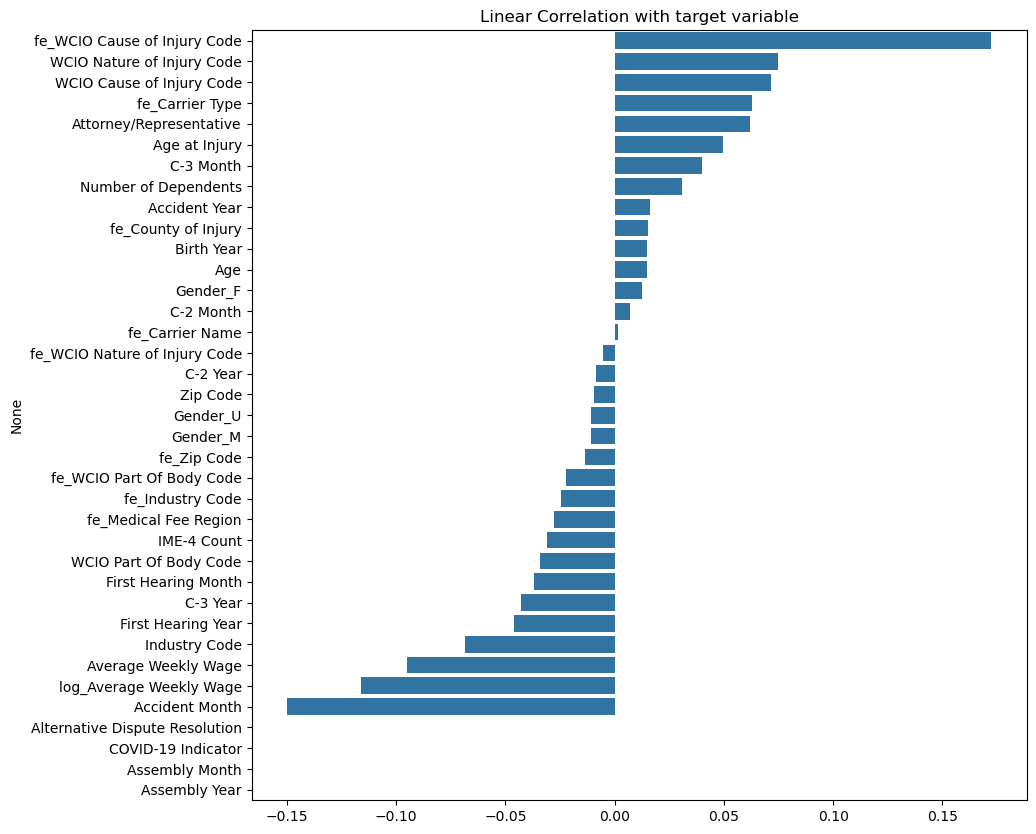

In [52]:
corr_y = df_train[num_features].corrwith(y_train)
corr_y = corr_y.sort_values(ascending=False)

plt.figure(figsize=(10, 10))
sns.barplot(x=corr_y.values, y=corr_y.index)
plt.title('Linear Correlation with target variable')

plt.show()

#### entropy correlation

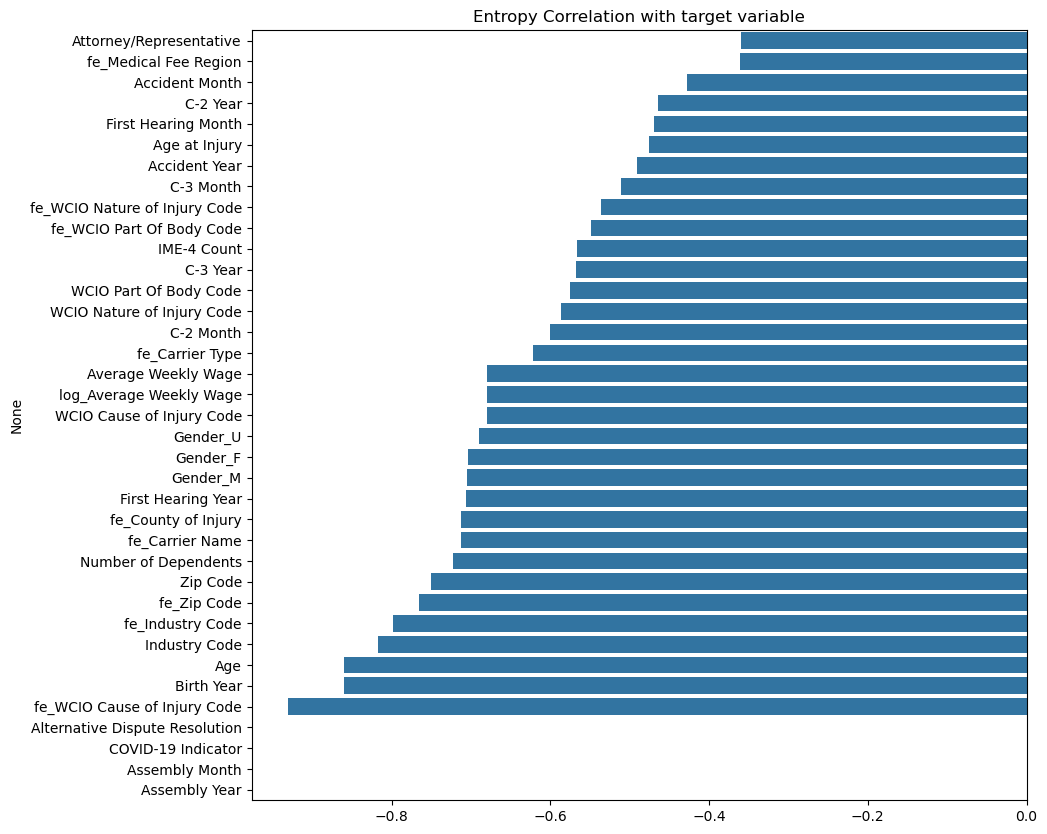

In [53]:
s_corr_y = []
for col in num_features:
    s_col = leo.two_col_entropy_corr(df_train[col], y_train)
    s_col = log((s_col +1)/2)
    s_corr_y.append(s_col)
    
s_corr_y = pd.Series(s_corr_y, index=num_features).sort_values(ascending=False)
s_corr_y = s_corr_y.sort_values(ascending=False)

plt.figure(figsize=(10, 10))
sns.barplot(x=s_corr_y.values, y=s_corr_y.index)
plt.title('Entropy Correlation with target variable')
plt.show()  

#### chi2 correlation for categorical features

In [54]:
from scipy.stats import chi2_contingency

Text(0.5, 0, 'x')

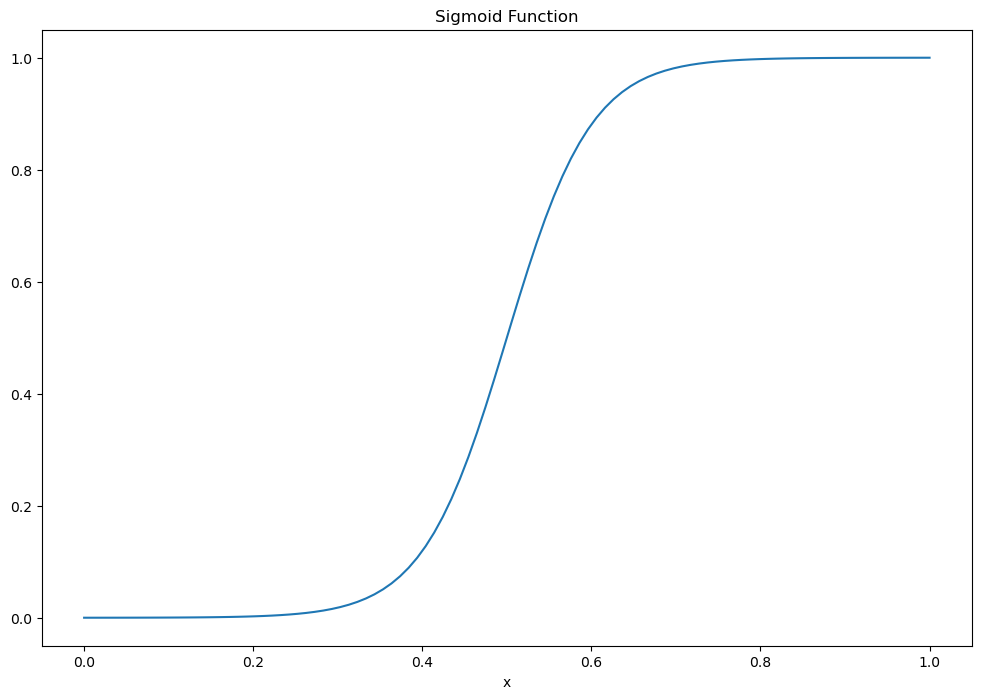

In [55]:
def sigmoid(x, a=20):
    return 1 / (1 + np.exp(-a * (x - 0.5)))

plt.figure(figsize=(12, 8))
x = np.linspace(0, 1, 100)
y = sigmoid(x)
plt.plot(x, y)
plt.title('Sigmoid Function')
plt.xlabel('x')

In [56]:
def chi2_feature_importance(f1, target, significance_level=0.05, log=False):
    """
    Evaluate if a feature is important to predict the target using the Chi-squared test.

    Parameters:
        data (pd.DataFrame): The dataset containing the feature and target.
        feature (str): The name of the feature column.
        target (str): The name of the target column.
        significance_level (float): The threshold for statistical significance (default 0.05).

    Returns:
        dict: A dictionary containing the chi-squared statistic, p-value, and whether the feature is important.
    """
    # Create a contingency table
    contingency_table = pd.crosstab(f1, target)

    # Perform the Chi-squared test
    chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)

    total_observations = contingency_table.sum().sum()
    rows, cols = contingency_table.shape

    cramers_v = np.sqrt(
        chi2_stat / (total_observations * min(cols - 1, rows - 1)))

    is_important = p_value < significance_level

    if log:
        if cramers_v < 0.3:
            print(f" {is_important} the test is not significant {cramers_v}")
        elif cramers_v < 0.5:
            print(f" {is_important} the test is weakly significant {cramers_v}")
        elif cramers_v < 0.7:
            print(f" {is_important} the test is moderately significant {cramers_v}")
        elif cramers_v < 1:
            print(f" {is_important} the test is highly significant {cramers_v}")
        else:
            print(f"the test has no sense {cramers_v}")

    # Determine if the feature is important
    is_important = p_value < significance_level
    return cramers_v, p_value

In [57]:
df_train[col]

Claim Identifier
5394068   -0.157895
5394838   -0.157895
5393780    0.184211
5393860    0.184211
5394440   -0.105263
             ...   
5394900   -0.210526
5394590    4.421053
5394571    4.421053
5394652    4.421053
5394512   -0.184211
Name: fe_Carrier Name, Length: 767, dtype: float64

Feature: Carrier Name
 False the test is weakly significant 0.4853694281067693
normalized score: 0.00831764442646089
--------------------------------------------------
Feature: Carrier Type
 False the test is not significant 0.0682546621509461
normalized score: 9.477507646660418e-05
--------------------------------------------------
Feature: County of Injury
 False the test is not significant 0.25341175678916344
normalized score: 0.0011632264734592168
--------------------------------------------------
Feature: District Name
 False the test is not significant 0.0786423820803295
normalized score: 6.756008762337494e-05
--------------------------------------------------
Feature: Gender
 False the test is not significant 0.016217678569078485
normalized score: 6.024444926805465e-06
--------------------------------------------------
Feature: Medical Fee Region
 False the test is not significant 0.07468181553478706
normalized score: 0.0001274053084260278
---------------------------------------

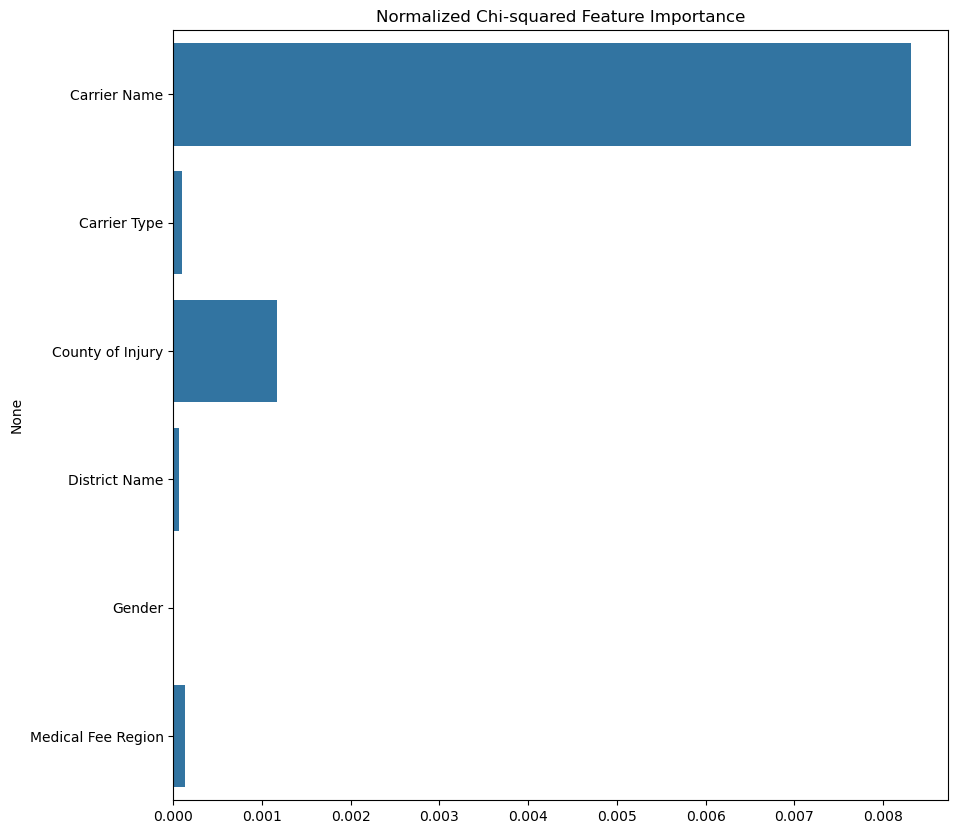

In [58]:
normalized_scores = []
 
for col in obj_features:
    print(f"Feature: {col}")
    cramers_v, p_value = chi2_feature_importance(df_train[col], y_train, log=True)
    normalized_scores.append((1 - p_value)*sigmoid(cramers_v))
    print(f'normalized score: {normalized_scores[-1]}')
    print("-"*50)

plt.figure(figsize=(10, 10))
sns.barplot(x=normalized_scores, y=obj_features)
plt.title('Normalized Chi-squared Feature Importance')
plt.show()

#### best features level 1

In [59]:
best_lin = list((corr_y [corr_y.abs() > 0.3]).index)
best_ent = list((s_corr_y [s_corr_y > - 0.4]).index)
best_chi2 = list((pd.Series(normalized_scores, index=obj_features)[pd.Series(normalized_scores, index=obj_features) > 0.5]).index)

In [60]:
bestnum = set(best_lin + best_ent)
bestnum = list(bestnum)
bestnum.append('fe_Carrier Name')
bestnum

['fe_Medical Fee Region', 'Attorney/Representative', 'fe_Carrier Name']

In [61]:
best_chi2

[]

### correlation between features

#### Linear correlation

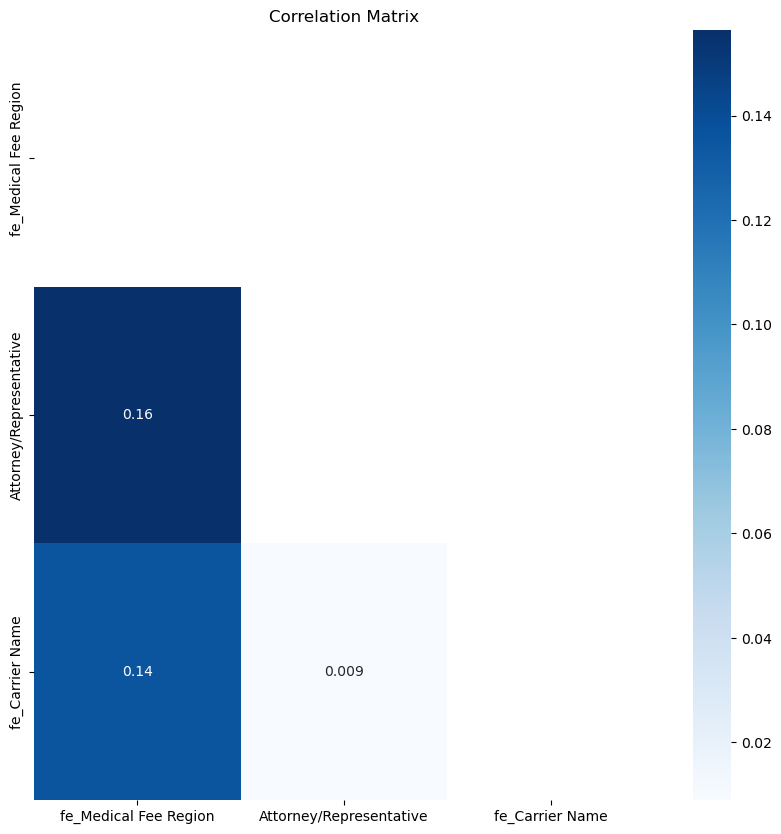

In [62]:
# correlation between numerical features
corr = df_train[bestnum].corr()
#half of the matrix
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(10, 10))
sns.heatmap(np.abs(corr), annot=True, cmap='Blues', mask=mask)
plt.title('Correlation Matrix')
plt.show()


#### entropy correlation

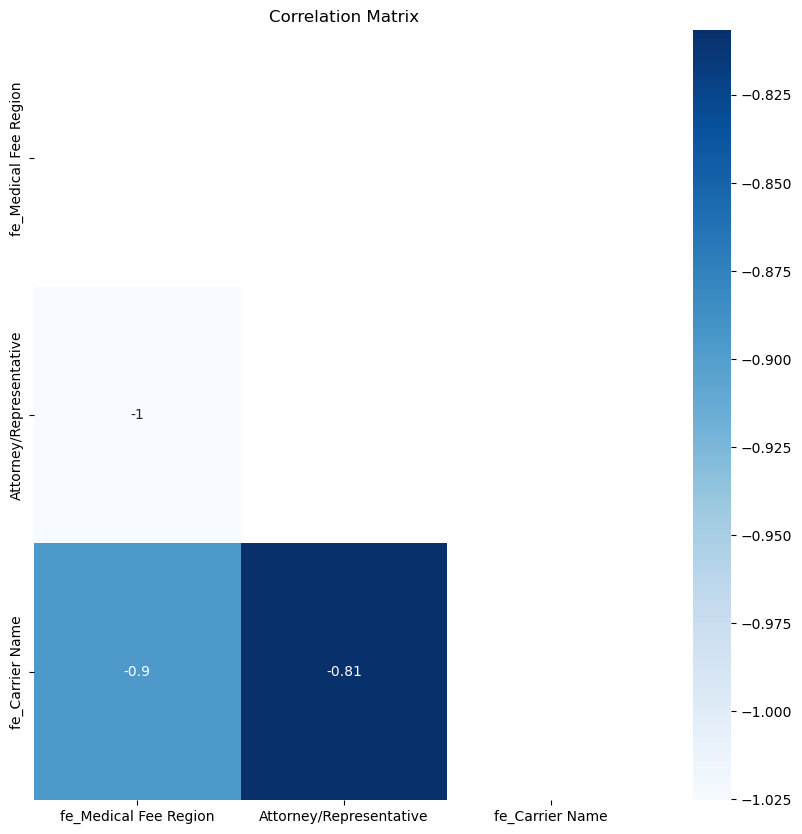

In [63]:
s_corr = leo.entropy_corr(df_train[bestnum])
#half of the matrix
mask = np.zeros_like(s_corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(10, 10))
sns.heatmap(s_corr, annot=True, cmap='Blues', mask=mask)
plt.title('Correlation Matrix')
plt.show()

#### best featues level 2


In [64]:
bestnum

['fe_Medical Fee Region', 'Attorney/Representative', 'fe_Carrier Name']

In [65]:
bestnum = ['fe_Zip Code',
 'C-3 Month',
 'C-3 Year',
 'fe_WCIO Cause of Injury Code',
 'log_Average Weekly Wage',
 'fe_WCIO Part Of Body Code',
 'Assembly Month',
 'First Hearing Month',
 'fe_Carrier Name']

### RFE

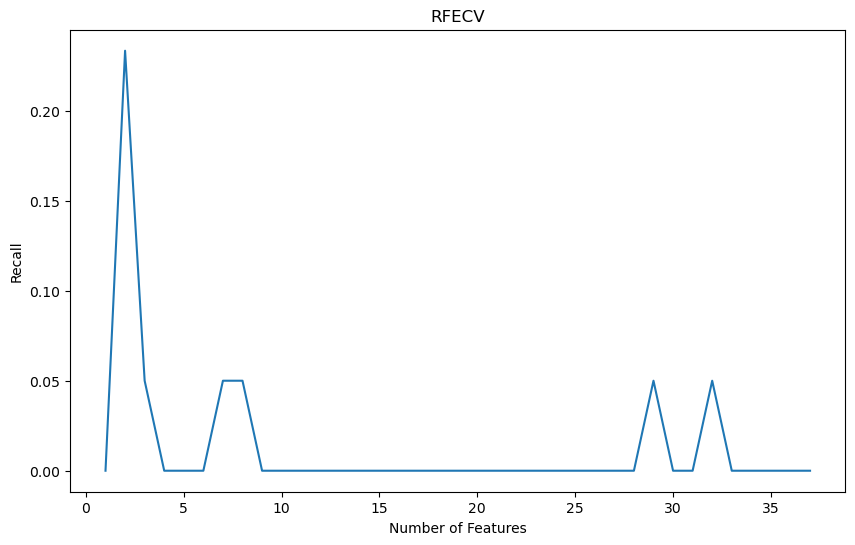

Optimal number of features: 2
Selected features: Index(['Zip Code', 'WCIO Part Of Body Code'], dtype='object')


In [66]:
# recoursive feature elimination
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
rfe = RFECV(model, cv=5, scoring='recall', n_jobs=-1)

rfe.fit(df_train[num_features], y_train)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(rfe.cv_results_['mean_test_score']) + 1), rfe.cv_results_['mean_test_score'])
plt.title('RFECV')
plt.xlabel('Number of Features')
plt.ylabel('Recall')
plt.show()

print(f'Optimal number of features: {rfe.n_features_}')
print(f'Selected features: {df_train[num_features].columns[rfe.support_]}')

/opt/anaconda3/envs/ML_env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/ML_env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

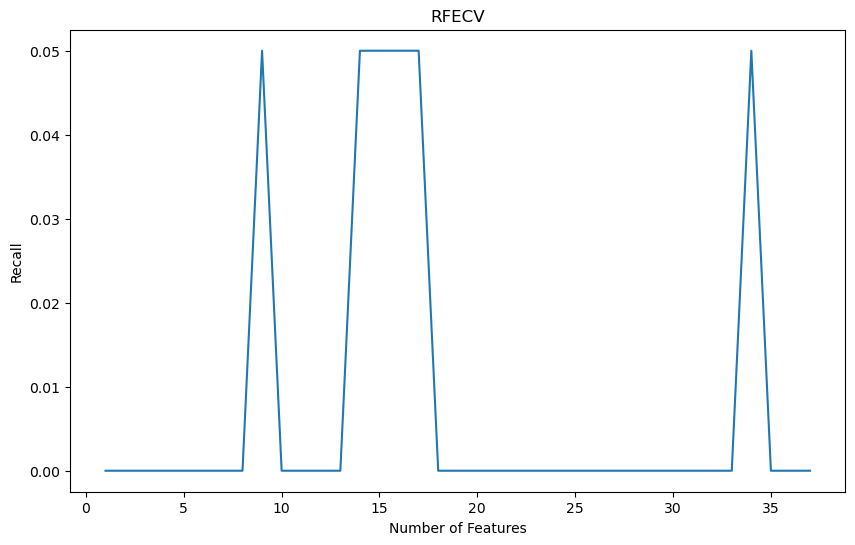

In [67]:
# recoursive feature elimination
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000)
rfe = RFECV(model, cv=5, scoring='recall', n_jobs=-1)

rfe.fit(df_train[num_features], y_train)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(rfe.cv_results_['mean_test_score']) + 1), rfe.cv_results_['mean_test_score'])
plt.title('RFECV')
plt.xlabel('Number of Features')
plt.ylabel('Recall')
plt.show()


# checkpoint 2

In [68]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from imblearn.combine import SMOTETomek
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
import lightgbm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier  # Import for ANN
# import the naive bayes module
from sklearn.naive_bayes import GaussianNB


## smote and tomek

In [69]:
df_train_np = df_train[bestnum].to_numpy()
y_train_np = y_train.to_numpy(dtype=int)

In [70]:

smote_tomek = SMOTETomek(sampling_strategy='auto')

# Ensure y_train contains integer values
y_train_int = y_train.round().astype('float64').to_numpy()
# Assuming you have your feature matrix X and target variable y
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(df_train_np, y_train_np)
df_train_resampled = pd.DataFrame(X_train_resampled, columns=bestnum)
y_train_resampled = pd.Series(y_train_resampled)

#smote = SMOTE(sampling_strategy='minority', random_state=42)

print("Resampling completed successfully!")

Resampling completed successfully!


In [71]:
y_train_resampled.value_counts()

0    743
1    743
Name: count, dtype: int64

## multiple model training

### sklearn models

In [72]:
# make grid search validation for every model in the list model_list_num

model_list_num = [
    SVC(),
    MLPClassifier(),
    GaussianNB(),
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    HistGradientBoostingClassifier()
]

model_names = ['SVC',
               'MLPClassifier',
               'GaussianNB',
               'LogisticRegression',
               'DecisionTreeClassifier',
               'RandomForestClassifier',
               'HistGradientBoostingClassifier'
]


best_params = []

param_grid_logistc = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear']
}

param_grid_tree = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10]
}

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10]
}

param_grid_hgb = {
    'max_iter': [100, 200, 300],
    'max_depth': [5, 10, 15, 20],
    'min_samples_leaf': [2, 5, 10]
}

param_grid_svc = {
    'C': [0.1, 1, 10],  # Common hyperparameters for SVC
    'kernel': ['linear', 'rbf']  # Try different kernels
}

param_grid_mlp = {  # Hyperparameters for ANN (MLPClassifier)
    'hidden_layer_sizes': [(100,), (100, 50), (100, 100)],  # Different hidden layer configurations
    'activation': ['relu', 'tanh'],  # Experiment with activation functions
    'solver': ['adam', 'lbfgs']  # Choose a suitable solver
}

param_grid_gnb = {  } # GaussianNB has no hyperparameters to tune
param_list = [param_grid_svc,
              param_grid_mlp,
              param_grid_gnb,
              param_grid_logistc,
              param_grid_tree,
              param_grid_rf,
              param_grid_hgb]
best_params = []

tn_list = []
fp_list = []
fn_list = []
tp_list = []

precision_score_list = []

for model, param_grid in zip(model_list_num, param_list):
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='precision', n_jobs=-1)
    grid_search.fit(X_train_resampled, y_train_resampled)
    best_params.append(grid_search.best_params_)
    print('-'*50)
    print(model)
    print(f"Best parameters for {model}: {grid_search.best_params_}")
    print(f"Best precision score: {grid_search.best_score_}")
    best_model = model.set_params(**grid_search.best_params_)
    best_model.fit(X_train_resampled, y_train_resampled)
    y_pred = best_model.predict(df_valid[bestnum])
    precision_score_model = precision_score(y_valid, y_pred)
    precision_score_list.append(precision_score_model)
    print(f"Recall: {recall_score(y_valid, y_pred)}")
    print(f"F1: {f1_score(y_valid, y_pred)}")
    print(f"ROC AUC: {roc_auc_score(y_valid, y_pred)}")
    cm = confusion_matrix(y_valid, y_pred)
    print(f"Confusion Matrix: \n{cm}")
    tn, fp, fn, tp = cm.ravel()
    
    tn_list.append(tn)
    fp_list.append(fp)
    fn_list.append(fn)
    tp_list.append(tp)
    pr = int(precision_score_model * 100)
    
    print(f"{YEQUALS}_pr{pr}_{model_names[model_list_num.index(model)]}_model")
    
    #leo.report_and_save(model = best_model,
    #                   model_name = f"{YEQUALS}_pr{pr}_{model_names[model_list_num.index(model)]}_model",
    #                   y_pred = y_pred,
    #                    y = y_valid,
    #                    feature_list = bestnum
    #                    )   
                        
                        

    
    
    
    
    



--------------------------------------------------
SVC()
Best parameters for SVC(): {'C': 10, 'kernel': 'rbf'}
Best precision score: 0.8335075098456871
Recall: 0.0
F1: 0.0
ROC AUC: 0.48663101604278075
Confusion Matrix: 
[[182   5]
 [  5   0]]
1_pr0_SVC_model


/opt/anaconda3/envs/ML_env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/ML_env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/ML_env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer

--------------------------------------------------
MLPClassifier()
Best parameters for MLPClassifier(): {'activation': 'relu', 'hidden_layer_sizes': (100, 50), 'solver': 'lbfgs'}
Best precision score: 0.9647389418287251
Recall: 0.0
F1: 0.0
ROC AUC: 0.5
Confusion Matrix: 
[[187   0]
 [  5   0]]
1_pr0_MLPClassifier_model
--------------------------------------------------
GaussianNB()
Best parameters for GaussianNB(): {}
Best precision score: 0.6514246896927869
Recall: 0.8
F1: 0.09195402298850575
ROC AUC: 0.6914438502673798
Confusion Matrix: 
[[109  78]
 [  1   4]]
1_pr4_GaussianNB_model
--------------------------------------------------
LogisticRegression()
Best parameters for LogisticRegression(): {'C': 100, 'solver': 'liblinear'}
Best precision score: 0.791219861494828
Recall: 0.0
F1: 0.0
ROC AUC: 0.4518716577540107
Confusion Matrix: 
[[169  18]
 [  5   0]]
1_pr0_LogisticRegression_model
--------------------------------------------------
DecisionTreeClassifier()
Best parameters for Dec

### xgboost

In [73]:
y_train_resampled_4_xgb = y_train_resampled
y_valid_4_xgb = y_valid


dtrain = xgb.DMatrix(df_train_resampled, label=y_train_resampled_4_xgb)
dvalid = xgb.DMatrix(df_valid[bestnum], label=y_valid_4_xgb)

# run a grid search for param_xgb
param_xgb = {
    'max_depth': [3, 5, 7],
    'eta': [0.1, 0.3, 0.5],
    'objective': ['binary:logistic']
}

grid = GridSearchCV(estimator=xgb.XGBClassifier(), param_grid=param_xgb, cv=5, scoring='precision', n_jobs=-1)
grid.fit(df_train_resampled, y_train_resampled_4_xgb)
print(grid.best_params_)

best_params_xgb = grid.best_params_

model_xgb = xgb.XGBClassifier(**best_params_xgb)
model_xgb.fit(df_train_resampled, y_train_resampled_4_xgb)
y_pred_xgb = model_xgb.predict(df_valid[bestnum])
pr = precision_score(y_valid_4_xgb, y_pred_xgb)
precision_score_list.append(pr)
cm = confusion_matrix(y_valid_4_xgb, y_pred_xgb)
print(f"Accuracy: \n{accuracy_score(y_valid_4_xgb, y_pred_xgb)}")
print(f"Precision: \n{pr}")
print(f"Recall: \n{recall_score(y_valid_4_xgb, y_pred_xgb)}")
print(f"F1: \n{f1_score(y_valid_4_xgb, y_pred_xgb)}")
print(f"ROC AUC: \n{roc_auc_score(y_valid_4_xgb, y_pred_xgb)}")
print(f"Confusion Matrix: \n{confusion_matrix(y_valid_4_xgb, y_pred_xgb)}")
tn, fp, fn, tp = cm.ravel()
tn_list.append(tn)
fp_list.append(fp)
fn_list.append(fn)
tp_list.append(tp)
model_names.append('XGBClassifier')


pr = int(pr*100)
print(f"{YEQUALS}_pr{pr}_XGBClassifier_model")
#leo.report_and_save(model= model_xgb,
#                    y_pred = y_pred_xgb,
#                    y = y_valid_4_xgb,
#                    model_name = f"{YEQUALS}_{acc}_model_XGBClassifier",
#                    feature_list = num_features_to_run)

model_names.append('XGBClassifier')
model_list_num.append(model_xgb)
tn, fp, fn, tp = confusion_matrix(y_valid_4_xgb, y_pred_xgb, normalize='pred').ravel()
tn_list.append(tn)
fp_list.append(fp)
fn_list.append(fn)
tp_list.append(tp)



{'eta': 0.5, 'max_depth': 7, 'objective': 'binary:logistic'}
Accuracy: 
0.9739583333333334
Precision: 
0.0
Recall: 
0.0
F1: 
0.0
ROC AUC: 
0.5
Confusion Matrix: 
[[187   0]
 [  5   0]]
1_pr0_XGBClassifier_model


In [75]:
y_train_resampled_4_lightgbm = y_train_resampled
y_valid_4_lightbm = y_valid

param_lightgbm = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.3, 0.5],
    'objective': ['binary']
}

grid = GridSearchCV(estimator=lightgbm.LGBMClassifier(), param_grid=param_lightgbm, cv=5, scoring='precision', n_jobs=-1)
grid.fit(df_train_resampled, y_train_resampled_4_lightgbm)
print(grid.best_params_)
best_params_lightgbm = grid.best_params_

model_lightgbm = lightgbm.LGBMClassifier(**best_params_lightgbm)
model_lightgbm.fit(df_train_resampled, y_train_resampled_4_lightgbm)
y_pred_lightgbm = model_lightgbm.predict(df_valid[bestnum])
pr = precision_score(y_valid_4_lightbm, y_pred_lightgbm)
precision_score_list.append(pr)
cm = confusion_matrix(y_valid_4_lightbm, y_pred_lightgbm)
print(f"Accuracy: \n{accuracy_score(y_valid_4_lightbm, y_pred_lightgbm)}")
print(f"Precision: \n{pr}")
print(f"Recall: \n{recall_score(y_valid_4_lightbm, y_pred_lightgbm)}")
print(f"F1: \n{f1_score(y_valid_4_lightbm, y_pred_lightgbm)}")
print(f"ROC AUC: \n{roc_auc_score(y_valid_4_lightbm, y_pred_lightgbm)}")
print(f"Confusion Matrix: \n{confusion_matrix(y_valid_4_lightbm, y_pred_lightgbm)}")
tn, fp, fn, tp = cm.ravel()
tn_list.append(tn)
fp_list.append(fp)
fn_list.append(fn)
tp_list.append(tp)
model_names.append('LGBMClassifier')
pr = int(pr*100)
print(f"{YEQUALS}_pr{pr}_LGBMClassifier_model")
#leo.report_and_save(model= model_lightgbm,
#                    y_pred = y_pred_lightgbm,
#                    y = y_valid_4_lightbm,
#                    model_name = f"{YEQUALS}_{acc}_model_LGBMClassifier",
#                    feature_list = num_features_to_run)




[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 594, number of negative: 594
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000657 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1159
[LightGBM] [Info] Number of data points in the train set: 1188, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with

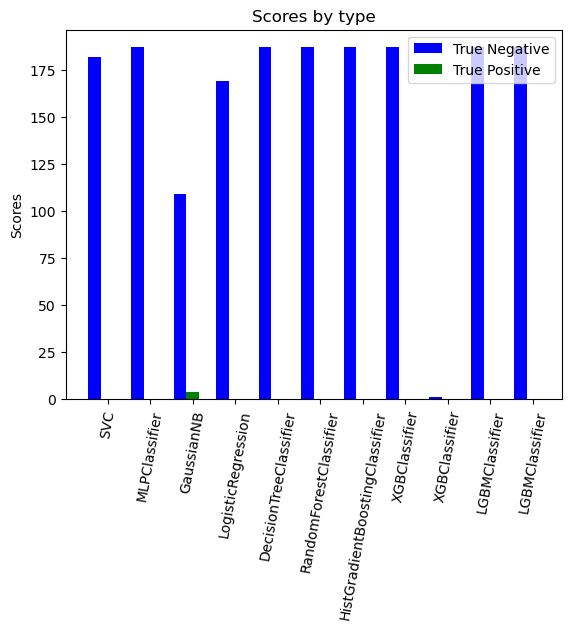

In [76]:
fig, ax = plt.subplots()
width = 0.3 # width of bar
x = np.arange(len(model_names))
ax.bar(x, tn_list, width, color='b', label='True Negative')
ax.bar(x + width, tp_list, width, color='g', label='True Positive')
# rotate the tick labels for better visibility
ax.set_xticklabels(model_names, rotation = 80)
ax.set_ylabel('Scores')
ax.set_title('Scores by type')

ax.set_xticks(x + width)
ax.set_xticklabels(model_names)
ax.legend()
plt.show()

# checkpoint 3

## recursive feature elimination

# checkpoint 4